In [1]:
import os
import math
import random
import numpy as np
import tensorflow as tf
import sys
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import scipy.misc
from datetime import datetime
import math
import time
from nets import preprocessing, SpinePathNet, metrics 
from datasets import convert_dicom_to_tfrecord as cdtt
from mpl_toolkits.axes_grid1 import make_axes_locatable #colorbar whose height (or width) in sync with the master axe
from matplotlib.colors import LinearSegmentedColormap
import tf_utils
import matplotlib.pyplot as plt
import tensorflow as tf
sys.path.append('../')
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0
isess = tf.InteractiveSession()

# Fold is one of five folds cross-validation. 
Fold = 1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
#Input-gan+lstm.
img_input = tf.placeholder(tf.float32, shape=(512, 512))
image_4d = tf.expand_dims(img_input, 0)
image_4d = tf.expand_dims(image_4d, -1)# add the batch dimension.
print (image_4d.shape)

logits,_,_= SpinePathNet.g_l_net(image_4d, batch_size=1, class_num=7, reuse=None, is_training=False, scope='g_SpinePathNet')

pred = tf.argmax(tf.nn.softmax(logits), dimension = 3)


                                                        
init_op = tf.group(tf.global_variables_initializer(),
                    tf.local_variables_initializer())
isess.run(init_op)
# checkpoint_dir.
loader = tf.train.Saver()
checkpoint_dir = 'tmp/tfmodels_gan_lstm_%s/'%Fold
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
if ckpt and ckpt.model_checkpoint_path:
    # Restores from checkpoint
    loader.restore(isess, ckpt.model_checkpoint_path)
    print("Restored model parameters from {}".format(ckpt))
else: 
    print('No checkpoint file found')

(1, 512, 512, 1)
INFO:tensorflow:Restoring parameters from tmp/tfmodels_gan_lstm_1/model.ckpt-9000
Restored model parameters from model_checkpoint_path: "tmp/tfmodels_gan_lstm_1/model.ckpt-9000"
all_model_checkpoint_paths: "tmp/tfmodels_gan_lstm_1/model.ckpt-9000"
all_model_checkpoint_paths: "tmp/tfmodels_gan_lstm_1/model.ckpt-10000"
all_model_checkpoint_paths: "tmp/tfmodels_gan_lstm_1/model.ckpt-11000"
all_model_checkpoint_paths: "tmp/tfmodels_gan_lstm_1/model.ckpt-12000"
all_model_checkpoint_paths: "tmp/tfmodels_gan_lstm_1/model.ckpt-12625"



In [5]:
class spinal_radiological_reports_generator():
    
    """
    It is to generate radiological reports for lumbar spines in MRIs.
    Input: predicted maps.
    Output: radiological reports.
    """
    """
    Input: predicted maps.
    Return: structured lists.    
    Three steps for post processing predicted maps:    
    Step 1: smooth pixels.     
    Step 2: labeling structures.    
    Step 3: generate structured lists, such as (L5, vertebra, normal).   
    """ 
    
    def __init__(self, prediction, class_number):
        #Below parameters are private by this obeject so called self.       
        assert len(prediction.shape) == 2 #guarantee the shape of predictions
        assert np.max(prediction) == class_number-1
        self.prediction = prediction
        self.weight = prediction.shape[1]
        self.height = prediction.shape[0]
        self.class_number = class_number
        self.SPINE_LABELS = {0 : 'Background',
                             1 : 'Normal Vertebral',
                             2 : 'Vertebral Deformity',
                             3 : 'Normal Disc',
                             4 : 'Gegenerative Disc',
                             5 : 'Normal Neural Foraminal',
                             6 : 'Neural Foraminal Stenosis'}
        

    def summarize_pixel_one_structure(self, spinal_structure):
        """
        Input: spinal structure.
        Return: segmented_points.
        """
        it = self.prediction
        if spinal_structure is "vertebrae":
            self.reserve = 2
            self.margin_x = 1
            self.margin_y = 2
        elif spinal_structure is "disc":
            self.reserve = 4
            self.margin = 10
        elif spinal_structure is "foramen":
            self.reserve = 6
            self.margin = 8
        else:
            print ("No spinal structure in this task called: %s" %spinal_structure)
            return None, None
        #self.x, self.y = np.where(it == self.reserve-1 and it == self.reserve) #coordinates 
        #reserve abnormal structures and change normal structures labels to abnormal
        #for i, j in enumerate(self.x):
        #    it[j][self.y[i]] = self.reserve           
        self.m, self.n = np.where(it <= self.reserve) and np.where(it >= self.reserve-1)
        #According x to smooth image.
        self.segmented_point = []
        self.segmented_point_end = []
        if spinal_structure is "vertebrae":
            for i, j in enumerate(self.m):
                if i > self.margin_x:
                    if self.m[i] - self.m[i-1] >= self.margin_x and self.n[i] - self.n[i-1] >= self.margin_y:
                        self.segmented_point.append(i) 
           # return self.segmented_point, self.x, self.y
        else:
            self.segmented_point.append(0)
            for i, j in enumerate(self.m):
                if i > self.margin:
                    if self.m[i] - self.m[i-1] > self.margin and self.m[i] - self.m[i-2] > self.margin \
                    and self.m[i] - self.m[i-4] > self.margin and self.m[i] - self.m[i-10] > self.margin:
                        self.segmented_point.append(i)  
                        self.segmented_point_end.append(i-1)
            self.segmented_point_end.append(len(self.m)-1)
            print (self.segmented_point,self.segmented_point_end)
            #return self.segmented_point, self.x, self.y
            
        """
        Input: one spinal structure and pixel margins,
        Output: one list represent the class of one type
        of structure at each location of a spine.
        """
        structural_list = []
        if len(self.segmented_point) >= 4 and len(self.segmented_point) <= 8:
            self.margins = self.segmented_point[-6:]#only acquire the last five bones from L1 to L5.
            self.margins_end = self.segmented_point_end[-6:]
            i = 0
            while i < len(self.margins):
                self.region = it[self.m[self.margins[i]:self.margins_end[i]]][self.n[self.margins[i]:self.margins_end[i]]]
                self.abnormal_points,_ = np.where(self.region==self.reserve)
                self.normal_points,_ = np.where(self.region==self.reserve-1)
                if len(self.abnormal_points) >= len(self.normal_points):
                    #print (len(self.abnormal_points),len(self.normal_points))
                    structural_list.append(1)
                else:
                    #print (len(self.abnormal_points),len(self.normal_points))
                    structural_list.append(0)      
                i += 1
            return structural_list
        else:
            print ("The threshold value %d is unsuitable in this sample!" %self.margin)
            return None
        
    def summarize_pixel_all_structure(self):
        """
        Input None,
        Return three types of spinal structure.
        """
        disc_condition = summarize_pixel_one_structure("disc")
        foramen_condition = summarize_pixel_one_structure("foramen")
        vertebrae_condition = summarize_pixel_one_structure("vertebrae")
        return disc_condition, foramen_condition, vertebrae_condition
        
        
    
    def report_generation(self):
    
        """
        Input: generate structured lists, such as (L5, vertebra, normal).
        Return: radiological reports.
        """
        radiological_report = []
        disc_condition, foramen_condition, vertebrae_condition = summarize_pixel_all_structure()
        l = len(disc_condition)
        if l == 5:
            MR_descriptions = "This spine is normally imaged in the sigattal direction."
            radiological_report.append(MR_descriptions)
            for i, j in enumerate(disc_condition):
                
                if j == 0 and foramen_condition[i] == 0 and vertebrae_condition[i] == 0:
                    if i < l-1:
                        descriptions = "At L%d-L%d, the intervertebral disc does not have obvious degenerative changes.\
                        The neural foramina does noes have obvious stenosis. The above vertebra does not have deformative changes." %(i+1, i+2)
                    else:
                        descriptions = "At L%d-S1, the intervertebral disc does not have obvious degenerative changes.\
                        The neural foramina does noes have obvious stenosis. The above vertebra does not have deformative changes." %i+1
                
                elif j == 0 and foramen_condition[i] == 0 and vertebrae_condition[i] == 1:
                    if i < l-1:
                        descriptions = "At L%d-L%d, the intervertebral disc does not have obvious degenerative changes.\
                        The neural foramina does noes have obvious stenosis. The above vertebra has Deformative changes." %(i+1, i+2)
                    else:
                        descriptions = "At L%d-S1, the intervertebral disc does not have obvious degenerative changes.\
                        The neural foramina does noes have obvious stenosis. The above vertebra has Deformative changes." %i+1
                        
                elif j == 0 and foramen_condition[i] == 1 and vertebrae_condition[i] == 0:
                    if i < l-1:
                        descriptions = "At L%d-L%d, the intervertebral disc does not have obvious degenerative changes.\
                        The neural foramina has obvious stenosis. The above vertebra does not have deformative changes." %(i+1, i+2)
                    else:
                        descriptions = "At L%d-S1, the intervertebral disc does not have obvious degenerative changes.\
                        The neural foramina has obvious stenosis. The above vertebra does not have deformative changes." %i+1
                        
                
                elif j == 1 and foramen_condition[i] == 0 and vertebrae_condition[i] == 0:
                    if i < l-1:
                        descriptions = "At L%d-L%d, the intervertebral disc has obvious degenerative changes.\
                        The neural foramina does noes has obvious stenosis. The above vertebra does not have deformative changes." %(i+1, i+2)
                    else:
                        descriptions = "At L%d-S1, the intervertebral disc does has obvious degenerative changes.\
                        The neural foramina does noes has obvious stenosis. The above vertebra does not have deformative changes." %i+1
                
                elif j == 1 and foramen_condition[i] == 1 and vertebrae_condition[i] == 1:
                    if i < l-1:
                        descriptions = "At L%d-L%d, the intervertebral disc has obvious degenerative changes.\
                         The above vertebra also has deformative changes, which lead to neural foraminal stenosis to a certain extent." %(i+1, i+2)
                    else:
                        descriptions = "At L%d-S1, the intervertebral disc has obvious degenerative changes.\
                         The above vertebra also has deformative changes, which lead to neural foraminal stenosis to a certain extent." %i+1
                
                elif j == 1 and foramen_condition[i] == 1 and vertebrae_condition[i] == 0:
                    if i < l-1:
                        descriptions = "At L%d-L%d, disc degenerative changes are associated with neural foraminal stenosis.\
                         The above vertebra does not have deformative changes." %(i+1, i+2)
                    else:
                        descriptions = "At L%d-S1, disc degenerative changes are associated with neural foraminal stenosis.\
                         The above vertebra does not have deformative changes." %i+1
                        
                elif j == 0 and foramen_condition[i] == 1 and vertebrae_condition[i] == 1:
                    if i < l-1:
                        descriptions = "At L%d-L%d, vertebra degenerative changes are associated with neural foraminal stenosis.\
                         The intervertebral disc does not have degenerative changes." %(i+1, i+2)
                    else:
                        descriptions = "At L%d-S1, disc degenerative changes are associated with neural foraminal stenosis.\
                         The intervertebral disc does not have degenerative changes." %i+1
                        
                elif j == 1 and foramen_condition[i] == 0 and vertebrae_condition[i] == 1:
                    if i < l-1:
                        descriptions = "At L%d-L%d, the intervertebral disc has obvious degenerative changes.\
                        The neural foramina does noes has obvious stenosis. The above vertebra has deformative changes." %(i+1, i+2)
                    else:
                        descriptions = "At L%d-S1, the intervertebral disc does has obvious degenerative changes.\
                        The neural foramina does noes has obvious stenosis. The above vertebra has deformative changes." %i+1
                radiological_report.append(descriptions)
        if l < 5:
            MR_descriptions = "This spine is abnormally imaged in the sigattal direction."
            radiological_report.append(MR_descriptions)
        else:
            raise ValueError('A very specific bad thing happened that the number of one type of diagnosed structure is larger than five!')
            
        return radiological_report

(512, 512)
102.dcm
[0, 1023, 2231, 3795, 5166, 6420] [1022, 2230, 3794, 5165, 6419, 7700]
[1, 1, 0, 1, 1, 1]
              Image                             Ground truth                            Prediction


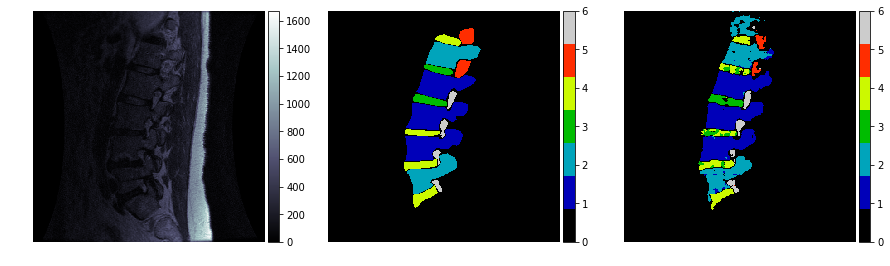

(512, 512)
106.dcm
[0, 608, 2281, 4165, 6168, 8004, 9608] [607, 2280, 4164, 6167, 8003, 9607, 10722]
[1, 0, 0, 1, 1, 1]
              Image                             Ground truth                            Prediction


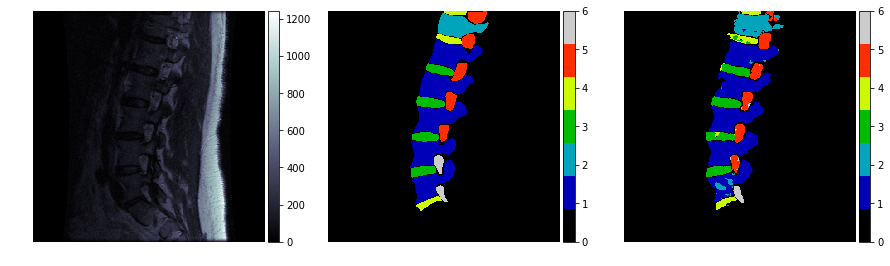

(512, 512)
111.dcm
[0, 202, 1206, 2451, 3884, 5632, 6891] [201, 1205, 2450, 3883, 5631, 6890, 8693]
[1, 1, 0, 0, 0, 1]
              Image                             Ground truth                            Prediction


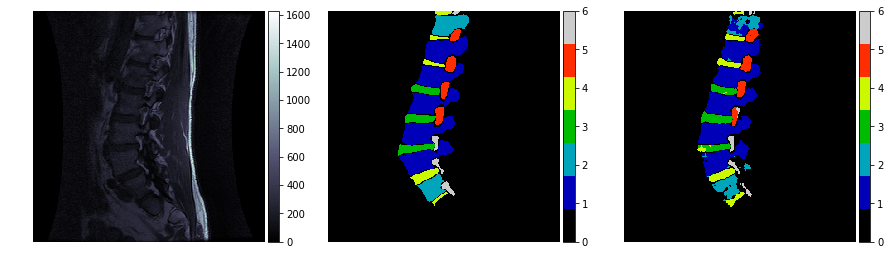

(512, 512)
115.dcm
[0, 487, 1323, 2399, 3624, 4967, 6288] [486, 1322, 2398, 3623, 4966, 6287, 8678]
[1, 1, 1, 0, 0, 1]
              Image                             Ground truth                            Prediction


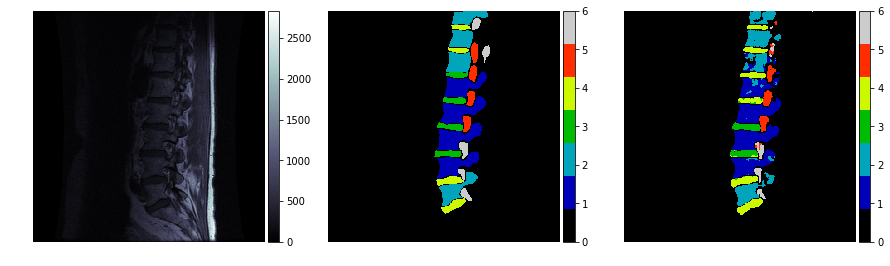

(512, 512)
126.dcm
[0, 526, 1735, 3059, 4379, 5593, 7100] [525, 1734, 3058, 4378, 5592, 7099, 7116]


IndexError: index 243 is out of bounds for axis 0 with size 16

In [6]:
from matplotlib.transforms import Bbox
path = 'datasets/spine_segmentation/spine_segmentation_%s/test/'%Fold
DIRECTORY_ANNOTATIONS = path + 'Annotations/'
DIRECTORY_IMAGES = path + 'Dicoms/'
image_names = sorted(os.listdir(DIRECTORY_IMAGES))##files list.
anno_names = sorted(os.listdir(DIRECTORY_ANNOTATIONS))
N = 7
def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap
    from the specified input map
    
    """

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    #return base.from_list(cmap_name, color_list, N)
    return LinearSegmentedColormap.from_list(cmap_name, color_list, N)


for i, j in enumerate(image_names):
    image=cdtt.get_image_data_from_dicom(DIRECTORY_IMAGES + image_names[i])
    _,mask_class,_,_,_,_ = cdtt.groundtruth_to_mask(DIRECTORY_ANNOTATIONS + anno_names[i])
    predictions = isess.run([pred], feed_dict={img_input:image})
    predictions = np.reshape(predictions,[512,512])
    print(j)
    #generate radiological reports.
    generator = spinal_radiological_reports_generator(predictions, N)
    x = generator.summarize_pixel_one_structure("disc")            
    print (x)
    print('              Image                             Ground truth                            Prediction')
    
    plt.figure(figsize = (15,15))
    
    #Raw image.
    ax_1 = plt.subplot(131)
    ax_1.set_axis_off()
    divider_1 = make_axes_locatable(ax_1)
    im_1 = ax_1.imshow(image,cmap= 'bone')
    cax_1 = divider_1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_1, cax=cax_1)
    
    #Ground truth.
    ax_2 = plt.subplot(132)
    ax_2.set_axis_off()
    im_2 = plt.imshow(mask_class,cmap= discrete_cmap(N, 'nipy_spectral'))# gist_ncar,CMRmap
    divider_2 = make_axes_locatable(ax_2)
    cax_2 = divider_2.append_axes("right", size="5%", pad=0.05)
    gt_1 = plt.colorbar(im_2, cax=cax_2)
    #plt.savefig('%sgt_%s.jpg'%(checkpoint_dir,j.split(".")[0]))#format='eps'
    
    # Prediction.
    ax_3  = plt.subplot(133)
    ax_3.set_axis_off()
    divider_3 = make_axes_locatable(ax_3)
    im_3 = ax_3.imshow(predictions,cmap= discrete_cmap(N, 'nipy_spectral'))
    cax_3 = divider_3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_3, cax=cax_3)
    plt.savefig('%splot_%s.pdf'%(checkpoint_dir,j.split(".")[0]), bbox_inches='tight', pad_inches=0, format='pdf', frameon=False,dpi=600,transparent=True, )
    #plt.axis('off')
    plt.show()

[653, 1202, 1674, 2107, 2422, 2787]
6609 0
4543 0
3149 0
1564 0
4380 0
[1, 1, 1, 1, 1]


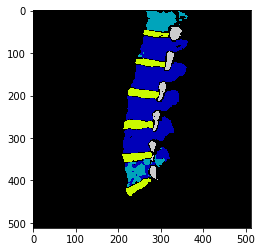

In [9]:
ax = plt.subplot()
ax.set_axis_on()
ax.imshow(predictions, cmap = discrete_cmap(N, 'nipy_spectral'))
generator = spinal_radiological_reports_generator(predictions,7)

x = generator.summarize_pixel_one_structure("disc")
print (x)